# Importing Packages

In [ ]:
# # # # # Uncomment VV for session restart
# !pip install git+https://github.com/ConradODriscoll/neurogym_copy
# !pip install git+https://github.com/DLR-RM/stable-baselines3
# !pip install git+https://github.com/Stable-Baselines-Team/stable-baselines3-contrib
# !pip install deepdiff

In [ ]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
from pathlib import Path
import json
from copy import deepcopy
from sklearn.decomposition import PCA
import itertools # Unused if not gridsearching
import logging


logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

device = 'cpu'
import neurogym as ngym

import warnings

# Suppress UserWarnings specifically from the 'gymnasium' module
warnings.filterwarnings("ignore", category=UserWarning, module="gymnasium")


import matplotlib.colors as mcolors
import matplotlib.patches as patches
from torch.nn import init
from torch.nn import functional as F
import pickle
from google.colab import drive

# Helper Functions

## Network Structure Visualisation

In [ ]:


def plot_weights_heatmap(weights_tensor, title, from_label, to_label, filename=None, highlight_diagonal=False):
    """
    Generates a flexible heatmap for any given weight matrix from a PyTorch model.

    Args:
        weights_tensor (torch.Tensor): The weight tensor to plot (e.g., from a nn.Linear layer).
        title (str): The title for the plot.
        from_label (str): The label for the x-axis ('From' units).
        to_label (str): The label for the y-axis ('To' units).
        filename (str, optional): File path to save the figure. If None, displays the plot. Defaults to None.
        highlight_diagonal (bool, optional): If True and the matrix is square, highlights the diagonal.
                                             Defaults to False.
    """
    # 1. Detach tensor from the computation graph and move to CPU as a NumPy array.
    weights = weights_tensor.detach().cpu().numpy()

    to_units, from_units = weights.shape

    # 2. Determine the symmetric colour range for consistency.
    max_abs_val = np.max(np.abs(weights))
    # Handle the case where all weights are zero to avoid a warning.
    if max_abs_val == 0:
        max_abs_val = 1
    norm = mcolors.Normalize(vmin=-max_abs_val, vmax=max_abs_val)

    # 3. Create the plot.
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(weights, cmap='bwr', norm=norm, interpolation='none', aspect='auto')

    # 4. Configure the colour bar.
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Connection Weight', rotation=270, labelpad=20, fontsize=12)

    # 5. Configure axes and labels using the provided arguments.
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_ylabel(to_label, fontsize=12)
    ax.set_xlabel(from_label, fontsize=12)

    # 6. Configure ticks.
    # We can't label every tick for large matrices, so we'll label every 5th or 10th.
    tick_step = max(1, from_units // 10)
    ax.set_xticks(np.arange(0, from_units, tick_step))
    ax.set_yticks(np.arange(0, to_units, tick_step))
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # 7. Add internal grid lines and borders.
    ax.set_xticks(np.arange(-.5, from_units, 1), minor=True)
    ax.set_yticks(np.arange(-.5, to_units, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Add a border for the diagonal cells only if the matrix is square and requested.
    if from_units == to_units and highlight_diagonal:
        for i in range(from_units):
            rect = patches.Rectangle(
                (i - 0.5, i - 0.5), 1, 1,
                linewidth=0.75, edgecolor='black', facecolor='none', alpha=0.7
            )
            ax.add_patch(rect)

    fig.tight_layout(pad=1.5)

    # 8. Save or display the figure.
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {filename}")
        plt.close(fig)
    else:
        plt.show()

# NeuroGym Task - Delay Match Sample (32D / Distractor 32D) - EDA

## Delay Match Sample Distractor

EDA on the DelayMatchSample 1D task with new added changes:
- Sample stim is selected from the arrangement of evenly spaced theta values (our input dimensions)
- Test stims where not matching are selected from the same arrangement of theta but without the sample instead of a random sampled theta
- Ability to use input noise via sigma
- Ability to use any value for dim ring

In [ ]:
timing_eda_0 = {
            'fixation': 300,
            'sample': 500,
            'delay1': 1000,
            'test1': 500,
            'delay2': 1000,
            'test2': 500,
            'delay3': 1000,
            'test3': 500}
# training_timings = {
#             'fixation': 500,
#             'sample': ('choice', (400, 600, 800, 900)),
#             'delay1': ('choice', (400, 600, 800, 900)),
#             'test1': ('choice', (400, 600, 800, 900)),
#             'delay2': ('choice', (400, 600, 800, 900)),
#             'test2': ('choice', (400, 600, 800, 900)),
#             'delay3': ('choice', (400, 600, 800, 900)),
#             'test3': ('choice', (400, 600, 800, 900))}
# Assign Time step size and calculate sequence length of a full trial


time_step_eda_0 = 50 #ms

length_of_trial = sum(timing_eda_0.values())
sequence_length_eda_0 = int(length_of_trial / time_step_eda_0)
print(f'Sequence length is {sequence_length_eda_0}')
batch_size_eda_0 = 2
task_name_eda_0 = 'DelayMatchSampleDistractor1D-v0'

kwargs_eda_0 = {'dt' : time_step_eda_0, 'timing': timing_eda_0, 'sigma': 0.05, 'dim_ring':32}

dataset_eda_0 = ngym.Dataset(task_name_eda_0, env_kwargs=kwargs_eda_0, batch_size=batch_size_eda_0) # Can pass env_kwargs = kwargs if need to pass kwargs

# dataset docstring says ; sequence length , batch size , input/output unit (size).
## Do we want to change this ordering? (I seem to remember batch first being an issue?)


Sequence length is 106


In [ ]:

env_eda_0 = dataset_eda_0.env


In [ ]:

inputs_eda_0, targets_eda_0 = dataset_eda_0()


inputs_eda_0 = torch.from_numpy(inputs_eda_0).type(torch.float)
targets_eda_0 = torch.from_numpy(targets_eda_0).type(torch.float)
# Visualise environment w sample trials in the same way as they do in the NGym Environment Docs

# _ = ngym.utils.plot_env(env_eda_0, num_trials=1)

input_size_eda_0 = env_eda_0.observation_space.shape[0]
output_size_eda_0 = env_eda_0.action_space.n
print(f'Output size is {output_size_eda_0}')
print('Input has shape (SeqLen, Batch, Dim) =', inputs_eda_0.shape)
print('Target has shape (SeqLen, Batch) =', targets_eda_0.shape) # = index of output layer unit that should be most active

Output size is 2
Input has shape (SeqLen, Batch, Dim) = torch.Size([1000, 2, 33])
Target has shape (SeqLen, Batch) = torch.Size([1000, 2])


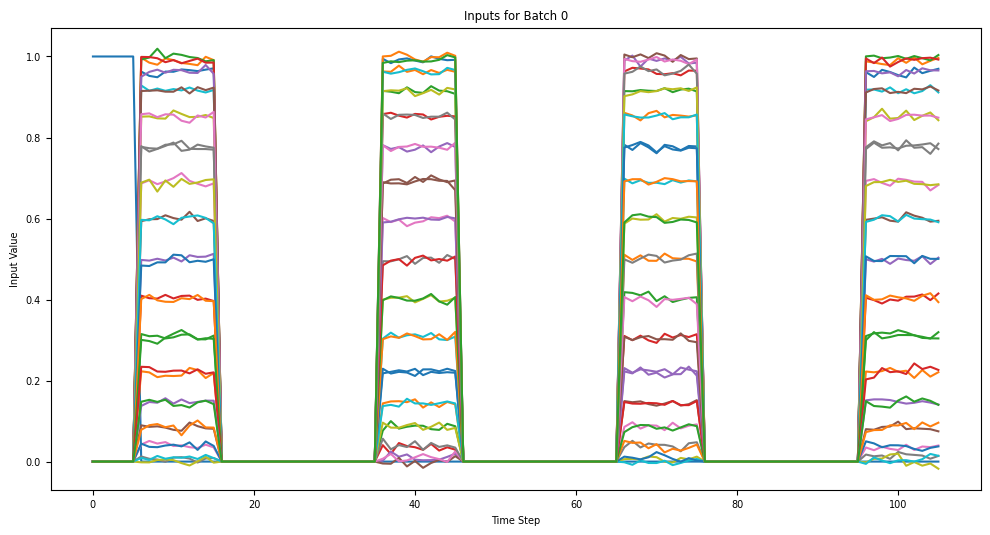

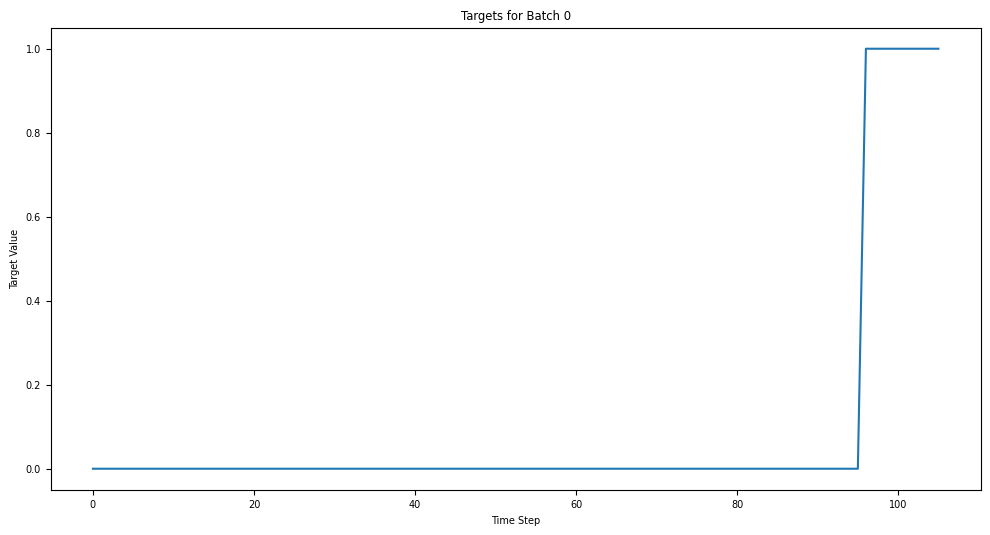

In [ ]:

# Select one batch (e.g., the first batch, index 0)
batch_index = 0
n = 2
m = n -1
# Plot inputs for the selected batch
plt.figure(figsize=(12, 6))
plt.plot(inputs_eda_0[sequence_length_eda_0*m:sequence_length_eda_0*n, batch_index, :].numpy())
plt.title(f'Inputs for Batch {batch_index}')
plt.xlabel('Time Step')
plt.ylabel('Input Value')
# plt.legend(['Fixation Input']+[f'Input Dimension {i+1}' for i in range(1,inputs_eda_0.shape[2]-1)])
plt.show()

# Plot targets for the selected batch
plt.figure(figsize=(12, 6))
plt.plot(targets_eda_0[sequence_length_eda_0*m:sequence_length_eda_0*n, batch_index].numpy())
plt.title(f'Targets for Batch {batch_index}')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.show()

In [ ]:
env_eda_0 = dataset_eda_0.env
trial_info = env_eda_0.new_trial()
print(trial_info)

{'ground_truth': np.int64(3), 'sample': np.float64(5.105088062083414), 'test1': np.float64(0.5890486225480862), 'test2': np.float64(3.730641276137879), 'test3': np.float64(5.105088062083414)}


In [ ]:
observations_eda_0, targets_eda_0 = env_eda_0.ob, env_eda_0.gt

In [ ]:
print(observations_eda_0.shape)
print(type(observations_eda_0))

(106, 33)
<class 'numpy.ndarray'>


In [ ]:
print(targets_eda_0.shape)

(106,)


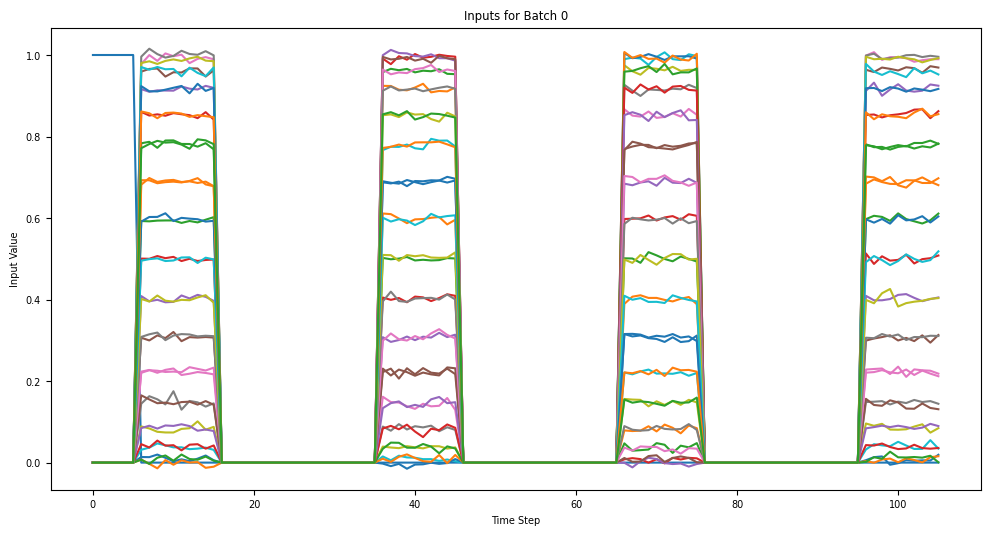

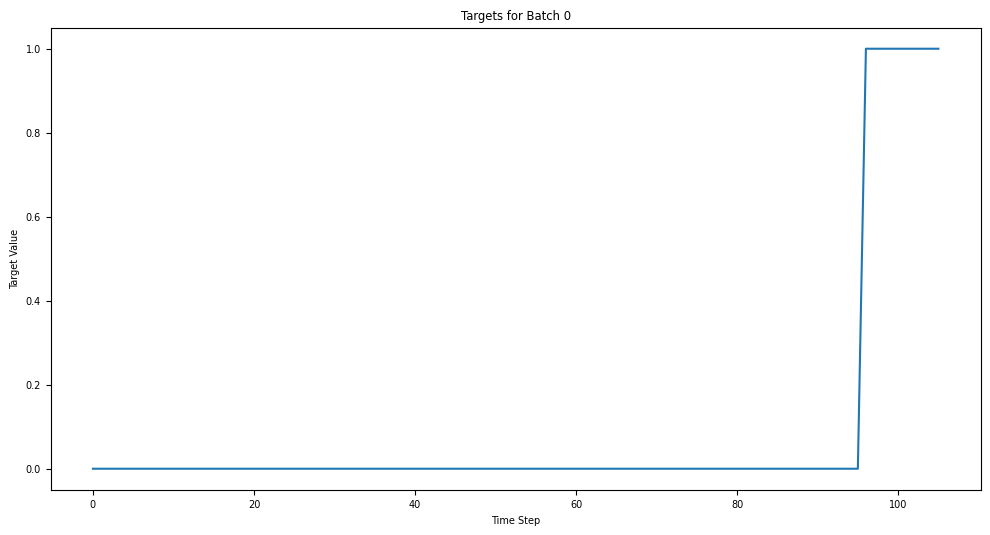

In [ ]:
# Plot inputs for the selected batch
plt.figure(figsize=(12, 6))
plt.plot(observations_eda_0[:, :])
plt.title(f'Inputs for Batch {batch_index}')
plt.xlabel('Time Step')
plt.ylabel('Input Value')
# plt.legend(['Fixation Input']+[f'Input Dimension {i+1}' for i in range(1,inputs_eda_0.shape[2]-1)])
plt.show()

# Plot targets for the selected batch
plt.figure(figsize=(12, 6))
plt.plot(targets_eda_0[:, np.newaxis])
plt.title(f'Targets for Batch {batch_index}')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.show()

# ----- ONLY LOCATION WE Set Up Dataset -----

# BRINGING IN DEVELOPED DATA LOADER FUNCTIONS

# ----- Developed Data Loader and Loss Masking -----

In [ ]:
# make however first, then see if we can split it up so that elements that are invariant across a training process can be separated (for efficiency)
def data_loader_abba(dataset_environment, batch_size, decision_grace_period=3, distractor_task=True):

  ### DETERMINE DIMENSIONS FOR INPUT / OUTPUT TENSORS

  # DETERMINE MAX SEQ LEN FROM ENV.TIMING
  env_timing_dict = dataset_environment.timing
  max_seq_len = int(max_seq_len_from_env_timing(env_timing_dict)/dataset_environment.dt)
  # print(f'Max sequence length is {max_seq_len}')
  # DETERMINE OTHER DIMENSIONS (INPUT SIZE OUTPUT SIZE ETC)
  input_size = dataset_environment.observation_space.shape[0] if len(dataset_environment.observation_space.shape) > 0 else 1 # Handling for 1d input vs multi dim
  # print(f'Input size is {input_size}')
  output_size = dataset_environment.action_space.shape[0] if len(dataset_environment.action_space.shape) > 0 else 1 # Handling for 1d input vs multi dim
  # print(f'Output size is {output_size}')

  # For the ground truth attention map
  dim_ring = dataset_environment.dim_ring # Get dim_ring from the env

  # HAVE BATCH SIZE, OBSERVATION SIZE, OUTPUT SIZE  (ALL WE NEED TO ITERATIVELY CREATE NEW TENSORS) (ACTUALLY, LETS MAKE THE WHOLE BATCH NOW AND JUST EDIT IN LOOP)

  OBSERVATION_TENSOR = torch.zeros((max_seq_len, batch_size, input_size))
  GROUND_TRUTH_TENSOR = torch.zeros((max_seq_len, batch_size, output_size))
  TASK_LOSS_MASK = torch.zeros((max_seq_len, batch_size))
  ATTENTION_MAP_MASK = torch.zeros((max_seq_len, batch_size))
  L2A_LOSS_MASK = torch.zeros((max_seq_len, batch_size))

  ATTENTION_TARGET_MAP_TENSOR = torch.zeros((batch_size, input_size - 1)) # Assuming input_size includes fixation bit (we will handle for the various handling options of fixation)

  # For the ground truth attention map
  dim_ring = dataset_environment.dim_ring # Get dim_ring from the env

  for batch_p in range(batch_size):
    trial_info_p = dataset_environment.new_trial()
    '''
    trial_info_p is dict like: (FOR DMSD)
    {'ground_truth': np.int64(1),
    'sample': np.float64(1.9634954084936207),
    'test1': np.float64(1.9634954084936207),
    'test2': np.float64(5.497787143782138),
    'test3': np.float64(4.71238898038469)}
    '''

    observations_batch_p, targets_batch_p = dataset_environment.ob, dataset_environment.gt


    task_trial_length = observations_batch_p.shape[0]
    # FILL DATA IN THE MAIN TENSOR
    OBSERVATION_TENSOR[:task_trial_length, batch_p, :] = torch.from_numpy(observations_batch_p).type(torch.float)
    GROUND_TRUTH_TENSOR[:task_trial_length, batch_p, :] = torch.from_numpy(targets_batch_p[:,np.newaxis]).type(torch.int)

    # Creating the "ground truth" attention map
    sample_theta = trial_info_p['sample']

    target_map = create_target_attention_map(sample_theta, dim_ring, device=OBSERVATION_TENSOR.device)

    # Now move onto Loss Masking:

    # Obtain start end inds
    start_ind_dict = dataset_environment.start_ind
    end_ind_dict = dataset_environment.end_ind

    # Component Function (so we can easily edit the loss masking approach and use for different trials)
    # then we have 1 argument which is distractor_task = True or False -> Changes loss mask construction
    # passing:  task_trial_length, start_ind_dict, end_ind_dict, trial_info_p, decision_grace_period, distractor_task

    task_loss_mask_p, attention_map_loss_mask_p, L2A_loss_mask_p = loss_mask_construction(task_trial_length, start_ind_dict, end_ind_dict, trial_info_p, distractor_task=distractor_task, grace_period=decision_grace_period)



    # Populate masks with results of function (note hacky dimensionality handling since we are technically specifying a 1 dim to fill and providing a 2 dim (so we make it an artifical 2 dim to fill))
    TASK_LOSS_MASK[:task_trial_length, batch_p:batch_p+1] = torch.from_numpy(task_loss_mask_p).type(torch.int)
    ATTENTION_MAP_MASK[:task_trial_length, batch_p:batch_p+1] = torch.from_numpy(attention_map_loss_mask_p).type(torch.int)
    L2A_LOSS_MASK[:task_trial_length, batch_p:batch_p+1] = torch.from_numpy(L2A_loss_mask_p).type(torch.int)
    ATTENTION_TARGET_MAP_TENSOR[batch_p, :] = target_map


  return (OBSERVATION_TENSOR, GROUND_TRUTH_TENSOR,
            TASK_LOSS_MASK, ATTENTION_MAP_MASK,
            ATTENTION_TARGET_MAP_TENSOR, L2A_LOSS_MASK)

In [ ]:
# Component function to determine max possible timing from an env dict
def max_seq_len_from_env_timing(env_timing_dict):

  max_period_lengths = []

  for key, value in env_timing_dict.items():
    # print(f"{key}: {value}")
    # print(f"{type(value)}")
    if isinstance(value, int):
      max_period_lengths.append(value)
      continue
    elif isinstance(value, tuple):
      max_period_lengths.append(max(value[1]))
      continue
  return sum(max_period_lengths)


In [ ]:
def loss_mask_construction(task_trial_length, start_ind_dict, end_ind_dict, trial_info_p, distractor_task=True, grace_period=1):
  task_loss_mask = np.ones((task_trial_length,1))
  attention_map_loss_mask = np.zeros((task_trial_length,1))
  L2A_loss_mask = np.ones((task_trial_length,1))

  gt_test_period_str = f"test{int(trial_info_p['ground_truth'])}"
  gt_test_period_end_ind = end_ind_dict[gt_test_period_str]

  if distractor_task:
    #Attention Map Loss Mask (and task loss grace (reduce iterations))
    test_period_strs = ['test1', 'test2', 'test3']

    for test_period_str in test_period_strs:
      test_period_start_ind = start_ind_dict[test_period_str]
      test_period_end_ind = end_ind_dict[test_period_str]
      if test_period_start_ind > gt_test_period_end_ind:
        break
      else:
        attention_map_loss_mask[test_period_start_ind:test_period_end_ind,0] = 1
        if grace_period:
          task_loss_mask[test_period_start_ind:(test_period_start_ind+grace_period),0] = 0 # ToDo: Different approaches to grace period re degree of masking

    # Set to 0 beyond gt test period
    task_loss_mask[gt_test_period_end_ind:,0] = 0
    L2A_loss_mask[gt_test_period_end_ind:,0] = 0



  return task_loss_mask, attention_map_loss_mask, L2A_loss_mask





In [ ]:
def create_target_attention_map(sample_theta, dim_ring=32, device='cpu', fixation=True):
    # moved outside of the data loader function in case need to change approach
    """
    Generates the noise-free cosine encoding for a given sample theta value.

    Args:
        sample_theta (float): The ground truth angle of the sample stimulus.
        dim_ring (int): The number of dimensions in the stimulus encoding.
        device (torch.device): The device to create the tensor on.

    Returns:
        torch.Tensor: The target attention map of shape (1, dim_ring).
    """

    # Create the array of angles for each dimension
    theta_dims = np.linspace(0, 2 * np.pi, dim_ring, endpoint=False)

    # Calculate the cosine encoding (the same formula from neurogym)
    encoding = np.cos(theta_dims - sample_theta) * 0.5 + 0.5

    # Convert to a PyTorch tensor and add a batch dimension
    target_map = torch.from_numpy(encoding).float().unsqueeze(0).to(device)

    return target_map

In [ ]:
# #testing
# time_start = time.time()
# (observation_tensor_test, ground_truth_tensor_test, task_loss_mask_test, attention_map_loss_mask_test, attention_target_map_tensor_test) = data_loader_abba(dataset_environment=env_eda_1, batch_size=64, decision_grace_period=3, distractor_task=True)
# time_end = time.time()
# print(f' Data Loaded in {time_end-time_start}')

In [ ]:
# dont think it could handle DMS standard rn
# it would need:
# different loss masking (no task loss masking, just attention map masking)
# would be pretty easy to do


# ----- Loss Calculation & Testing Trial Outcome ------

### Losses Calculator Function

In [ ]:


def calculate_total_loss(task_outputs, attention_map_outputs, ground_truth_tensor,
                         task_loss_mask, attention_map_loss_mask,
                         attention_target_map, attention_loss_weight=0.1):
    """
    Calculates the combined task and attention loss for a batch of trials.

    Args:
        task_outputs (torch.Tensor): The decision output from the network
                                     (seq_len, batch_size, output_size).
        attention_map_outputs (torch.Tensor): The attention map from the network
                                              (seq_len, batch_size, attention_dim).
        ground_truth_tensor (torch.Tensor): The ground truth actions for the trials
                                            (seq_len, batch_size, 1).
        task_loss_mask (torch.Tensor): Mask to apply loss only on relevant time steps
                                       for the task (seq_len, batch_size).
        attention_map_loss_mask (torch.Tensor): Mask for attention loss (seq_len, batch_size).
        attention_target_map (torch.Tensor): The target encoding for the attention map
                                             (batch_size, attention_dim).
        attention_loss_weight (float): The weighting factor (gamma) for the attention loss.

    Returns:
        torch.Tensor: The final scalar loss value for the batch.
    """
    task_loss = torch.tensor(0.0)
    weighted_attention_loss = torch.tensor(0.0)

    # --- 1. Calculate the Primary Task Loss (e.g., Cross-Entropy) ---

    # Reshape tensors for the loss function
    # The output should be (N, C) where C is number of classes
    # The target should be (N)

    task_outputs_flat = task_outputs.view(-1, task_outputs.shape[-1])
    ground_truth_flat = ground_truth_tensor.view(-1).long()
    task_loss_mask_flat = task_loss_mask.view(-1)

    # Use 'reduction="none"' to get a loss value for each element
    loss_fn_task = nn.CrossEntropyLoss(reduction='none')

    # Calculate the raw, unmasked loss
    raw_task_loss = loss_fn_task(task_outputs_flat, ground_truth_flat)

    # Apply the mask and calculate the mean loss over valid time steps
    masked_task_loss = raw_task_loss * task_loss_mask_flat
    task_loss = masked_task_loss.sum() / (task_loss_mask_flat.sum() + 1e-8) # Add epsilon for safety

    if attention_loss_weight > 0 and attention_map_outputs is not None:
        # Reshape and expand the target map to match the network's output
        target_expanded = attention_target_map.unsqueeze(0).expand_as(attention_map_outputs)

        loss_fn_attn = nn.MSELoss(reduction='none')

        # Calculate raw MSE for every element
        raw_attn_loss = loss_fn_attn(attention_map_outputs, target_expanded)

        # We need to average over the feature dimension (dim=2) first
        raw_attn_loss_per_step = raw_attn_loss.mean(dim=2) # Shape becomes (seq_len, batch_size)

        # Apply the time mask
        masked_attn_loss = raw_attn_loss_per_step * attention_map_loss_mask

        attention_loss = masked_attn_loss.sum() / (attention_map_loss_mask.sum() + 1e-8)

        # Weight the attention loss (for returning)
        weighted_attention_loss = attention_loss_weight * attention_loss

        # --- 3. Combine the Losses ---


    total_loss = task_loss + weighted_attention_loss



    return total_loss, task_loss, weighted_attention_loss

### Evaluate Trial Outcome DMSD

In [ ]:


def validate_trial_final(task_output_trial, trial_info, start_ind_dict, end_ind_dict, num_last_steps_to_check=3):
    """
    Validates a trial using the final proposed logic:
    1. No 'MATCH' responses are allowed during ANY non-matching test period.
    2. The last N responses of the correct MATCH period must all be 'MATCH'.

    Args:
        task_output_trial (np.array): The decision output for a single trial
                                      (seq_len, output_size).
        trial_info (dict): The dictionary containing ground truth for the trial.
        start_ind_dict (dict): Dictionary of start indices for each trial period.
        end_ind_dict (dict): Dictionary of end indices for each trial period.
        num_last_steps_to_check (int): The number of final time steps in the
                                       ground truth period to check for a stable response.

    Returns:
        bool: True if the trial was successful, False otherwise.
    """

    ground_truth_period_num = int(trial_info['ground_truth'])
    MATCH_ACTION_IDX = 1

    # --- 1. Check ALL non-matching test periods for premature/incorrect MATCH responses ---
    all_test_periods = [1, 2, 3]
    for test_period_num in all_test_periods:
        # Skip the actual ground truth period for this check
        if test_period_num == ground_truth_period_num:
            continue

        period_name = f'test{test_period_num}'
        start_idx = start_ind_dict[period_name]
        end_idx = end_ind_dict[period_name]

        period_output = task_output_trial[start_idx:end_idx, :]

        # Determine the response at each time step in the period
        responses_per_timestep = np.argmax(period_output, axis=1)

        # If ANY response in this non-matching period was a MATCH, it's a failure
        if np.any(responses_per_timestep == MATCH_ACTION_IDX):
            return False

    # --- 2. If all non-matching periods are clean, check the ground truth period ---
    gt_period_name = f'test{ground_truth_period_num}'
    gt_start_idx = start_ind_dict[gt_period_name]
    gt_end_idx = end_ind_dict[gt_period_name]

    # Isolate the output for the last N steps of the ground truth period
    # Ensure we don't index past the beginning of the period if it's too short
    start_of_check = max(gt_start_idx, gt_end_idx - num_last_steps_to_check)
    last_steps_output = task_output_trial[start_of_check:gt_end_idx, :]

    # If there are no timesteps to check (e.g., a very short period), fail the trial (ERROR)
    if last_steps_output.shape[0] == 0:
        print('NO TIMESTEPS TO CHECK')
        return False

    # Determine the response at each of these last time steps
    last_responses = np.argmax(last_steps_output, axis=1)

    # If ALL of the last N responses were MATCH, the trial is a success
    if np.all(last_responses == MATCH_ACTION_IDX):
        return True

    # Otherwise, the trial is a failure
    return False

## Training Functions

### Validation

### Early Stop Validation

In [ ]:


def validate_network(net, dataset, num_trials=200):
    """
    Validation function (REQUIRES TASK_OUTPUTS as FIRST OF TWO returns from forward(self=net))
    """
    env = dataset.env
    env.reset()

    correct_trials = 0
    for i in range(num_trials):
        # Sample a new trial to get all necessary info
        trial_info = env.new_trial()
        ob, gt = env.ob, env.gt

        # Get the timing info for this specific trial
        start_ind_dict = env.start_ind
        end_ind_dict = env.end_ind

        # Convert to tensor for the network
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float).to(device)

        # --- ESSENTIAL CHANGE ---
        # The model now returns task_outputs and attention_maps. We only need the first for validation.
        task_outputs, _ = net(inputs)

        # Detach and convert to numpy for validation
        task_outputs_np = task_outputs.detach().cpu().numpy()[:, 0, :]

        # Use the final validation logic we developed
        is_correct = validate_trial_final(
            task_outputs_np,
            trial_info,
            start_ind_dict,
            end_ind_dict
        )

        if is_correct:
            correct_trials += 1

    # Calculate average performance
    avg_performance = correct_trials / num_trials

    return avg_performance


In [ ]:
def early_stop_validation(model_in_training, validation_set_dict, validation_trials=200):
    """Early stopping wrapper function"""
    performance_dict = {}
    for dataset_name, dataset in validation_set_dict.items():
        # Call the new adapted validation function
        avg_trial_performance_valid = validate_network(
            model_in_training, dataset, num_trials=validation_trials
        )
        performance_dict[dataset_name] = avg_trial_performance_valid
    return performance_dict

### L2 Activity Function

In [ ]:
import torch

def calculate_activity_loss(activity_tuple, activity_beta):
    """
    Calculates the total L2 activity penalty for a tuple of recurrent layer outputs.

    Args:
        activity_tuple (tuple of torch.Tensor): A tuple containing the activity tensors
                                                 (e.g., firing rates) from one or more
                                                 recurrent layers. Each tensor should have
                                                 shape (seq_len, batch_size, hidden_size).
        activity_beta (float): The regularization coefficient (lambda) to scale the loss.

    Returns:
        torch.Tensor: A scalar tensor representing the total L2 activity loss,
                      ready to be added to the main loss function.
    """
    # Initialise the total loss as a zero tensor on the correct device
    # We get the device from the first tensor in the tuple
    total_activity_loss = torch.tensor(0.0, device=activity_tuple[0].device)

    # Iterate through each layer's activity tensor provided in the tuple
    for activity_tensor in activity_tuple:
        # Calculate the L2 penalty for the current tensor: the mean of the squared activity
        # This encourages the network to keep firing rates low on average.
        l2_activity = torch.mean(activity_tensor**2)

        # Add the loss for this layer to the total
        total_activity_loss += l2_activity

    # Scale the final summed loss by the beta coefficient
    return activity_beta * total_activity_loss

In [ ]:
### UPDATE FOR MASKING - HOW STUPID I WAS

def calculate_activity_loss(activity_tuple, activity_beta, loss_mask):
    """
    Calculates the total L2 activity penalty using a mask to correctly handle
    variable-length trials with padding.

    Args:
        activity_tuple (tuple of torch.Tensor): A tuple containing the activity tensors
                                                 from one or more recurrent layers.
        activity_beta (float): The regularization coefficient.
        loss_mask (torch.Tensor): A mask of shape (seq_len, batch_size) that is 1 for
                                  active time steps and 0 for padded ones.

    Returns:
        torch.Tensor: A scalar tensor representing the correctly normalised L2 activity loss.
    """
    # Get the device from the first tensor in the tuple
    device = activity_tuple[0].device
    total_activity_loss = torch.tensor(0.0, device=device)

    # The mask needs to be expanded to match the shape of the activity tensors
    # for element-wise multiplication. Shape: (seq_len, batch_size, 1)
    mask_expanded = loss_mask.unsqueeze(-1)

    for activity_tensor in activity_tuple:
        # 1. Square the activity at every time step
        squared_activity = activity_tensor**2

        # 2. Apply the mask. This zeros out the activity for padded time steps.
        # We need to expand the mask to match the hidden_size dimension.
        masked_squared_activity = squared_activity * mask_expanded.expand_as(squared_activity)

        # 3. Sum the activity and divide by the number of active time steps.
        # This gives us the true mean squared activity, ignoring padding.
        # Add a small epsilon to avoid division by zero on an empty mask.
        mean_l2_activity = masked_squared_activity.sum() / (loss_mask.sum() * activity_tensor.shape[-1] + 1e-8)

        total_activity_loss += mean_l2_activity

    return activity_beta * total_activity_loss

### Main Training Function

In [ ]:


def training_with_early_stop_attention_nets(
    model,
    training_dataset,
    validation_set_dict,
    batch_size=64,
    max_steps=20000,
    min_validation_perf=0.8,
    patience=5,
    num_steps_for_early_stop_check=500,
    num_validation_trials=200,
    model_name='gated_rnn_model',
    tr_output_mode=False,
    attention_loss_weight=0.5, # will form around 1/6 of the total loss (guide )
    L2A = False,
    L2_beta = 0.035
):
    ### REQUIRES NET.forward TO return 2 things: outputs, attention_maps (s i.e. for whole trial)


    # Tracking Loss
    tr_epochs_loss, tr_total_loss = [], [] # total
    tr_task_loss = [] # task
    tr_attn_loss = [] # attention
    tr_act_loss = [] # activity


    tr_epochs_valid_perf, tr_valid_perfs_list_of_dicts, tr_valid_perfs_avg = [], [], []
    n_steps_first_th, n_steps_final = 0, 0

    # Setup
    optimiser = optim.Adam(model.parameters(), lr=0.001)

    # Loss Tracking
    running_total_loss = 0.0
    running_task_loss = 0.0
    running_attn_loss = 0.0
    running_act_loss = 0.0

    start_time = time.time()
    training_env = training_dataset.env

    print('Training network...')

    current_best_valid_accuracy_es = 0.0
    current_best_valid_accuracy_all = 0.0
    best_valid_performance_all = [0] * len(validation_set_dict)
    best_valid_performance_es = [0] * len(validation_set_dict)
    surpassed_threshold = False
    current_patience = patience
    model.train()
    model_save_name = f'{model_name}_best.pth'

    for i in range(max_steps):
        # Data generation and training step
        (inputs, ground_truth,
         task_mask, attn_mask,
         attn_target, L2A_mask) = data_loader_abba(training_env, batch_size=batch_size)

        inputs, ground_truth = inputs.to(device), ground_truth.to(device)
        task_mask, attn_mask = task_mask.to(device), attn_mask.to(device)
        attn_target = attn_target.to(device)

        optimiser.zero_grad()

        if L2A:
          task_outputs, attention_map_outputs, activity_tuple = model(inputs, track_outputs=True)

        else:
          task_outputs, attention_map_outputs = model(inputs)


        total_loss, task_loss, weighted_attention_loss = calculate_total_loss(
            task_outputs = task_outputs,
            attention_map_outputs = attention_map_outputs,
            ground_truth_tensor = ground_truth,
            task_loss_mask = task_mask,
            attention_map_loss_mask = attn_mask,
            attention_target_map = attn_target,
            attention_loss_weight=attention_loss_weight
        )
        if L2A:
          activity_loss = calculate_activity_loss(activity_tuple = activity_tuple, activity_beta = L2_beta, loss_mask = L2A_mask)
          total_loss += activity_loss



        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimiser.step()
        running_total_loss += total_loss.item()
        running_task_loss += task_loss.item()
        running_attn_loss += weighted_attention_loss.item()
        if L2A:
          running_act_loss += activity_loss.item()


        if i <= 1:
          print("--- First Step Losses to Check Beta----")
          print(f"Task Loss: {task_loss.item()}")
          print(f"Weighted Attention Loss: {weighted_attention_loss.item()}")
          print(f"Activity Loss: {activity_loss.item()}") if L2A else None
          print(f"Total Loss: {total_loss.item()}")
        if i % 100 == 99:
            running_total_loss /= 100
            running_task_loss /= 100
            running_attn_loss /= 100
            if L2A:
              running_act_loss /= 100


            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_total_loss, time.time() - start_time))
            # Print individual loss components on the same line


            print(f'Task Loss: {running_task_loss:.4f}, Attention Loss: {running_attn_loss:.4f}')
            if L2A:
              print(f'Activity Loss: {running_act_loss:.4f}')



            tr_epochs_loss.append(i+1)
            tr_total_loss.append(running_total_loss)
            tr_task_loss.append(running_task_loss)
            tr_attn_loss.append(running_attn_loss)

            if L2A:
              tr_act_loss.append(running_act_loss)

            running_total_loss, running_task_loss, running_attn_loss = 0, 0, 0

            if L2A:
              running_act_loss = 0


        if (i + 1) % num_steps_for_early_stop_check == 0:
            model.eval()
            with torch.no_grad():
                current_perf_dict = early_stop_validation(
                    model, validation_set_dict, num_validation_trials
                )

                print(f'Current Performance Dict: {current_perf_dict}')
                list_avg_perfs = list(current_perf_dict.values())
                average_perf = np.mean(list_avg_perfs)

                tr_epochs_valid_perf.append(i+1)
                tr_valid_perfs_list_of_dicts.append(current_perf_dict)
                tr_valid_perfs_avg.append(average_perf)

                print(f'Current Average Performance: {average_perf}')

                # --- CORRECTED EARLY STOPPING LOGIC ---

                # First, check if the threshold has been met
                status_list = [perf > min_validation_perf for perf in list_avg_perfs]
                if all(status_list) and not surpassed_threshold:
                    surpassed_threshold = True
                    n_steps_first_th = i + 1
                    num_steps_for_early_stop_check = 100 # Speed up checks
                    print("Performance threshold surpassed. Starting early stopping countdown.")

                # Always track the best performance seen at any point
                if average_perf > current_best_valid_accuracy_all:
                    current_best_valid_accuracy_all = average_perf
                    best_valid_performance_all = list_avg_perfs

                # Now, handle the early stopping logic which is active ONLY AFTER the threshold is passed
                if surpassed_threshold:
                    if average_perf > current_best_valid_accuracy_es:
                        current_best_valid_accuracy_es = average_perf
                        best_valid_performance_es = list_avg_perfs
                        torch.save(model.state_dict(), model_save_name)
                        current_patience = patience # Reset patience on new best

                    elif current_patience <= 0:
                        n_steps_final = i + 1
                        print('Early Stopping. I have run out of patience Grrr')
                        break

                    else:
                        # If performance is not a new best, and we have not run out of patience, decrease patience
                        current_patience -= 1


            model.train()

    learning_curve_dict = {
            'training_loss_epochs_list': tr_epochs_loss,
            'total_training_loss_values_list' : tr_total_loss,
            'task_training_loss_values_list' : tr_task_loss,
            'attention_training_loss_values_list' : tr_attn_loss,
            'activity_training_loss_values_list' : tr_act_loss,
            'validation_perf_epochs_list': tr_epochs_valid_perf,
            'validation_perf_dicts_list' : tr_valid_perfs_list_of_dicts,
            'validation_perf_avg_values_list' : tr_valid_perfs_avg,
            'n_steps_first_th' : n_steps_first_th,
            'n_steps_final' : n_steps_final
                }

    try:
        # Load the best model that was saved (which would only happen if it crossed the threshold)
        model.load_state_dict(torch.load(model_save_name))
        print('Best model loaded')
        for valid_set_name, perf in zip(validation_set_dict.keys(), best_valid_performance_es):
            print(f'Best {valid_set_name} performance: {perf}')

        if tr_output_mode:
            return model, learning_curve_dict
        return model
    except:
        print('No best model that satisfies validation threshold found')
        # This part for tracking best performance regardless of threshold is preserved
        current_best_valid_accuracy_all = max(tr_valid_perfs_avg) if tr_valid_perfs_avg else 0
        best_perf_idx = np.argmax(tr_valid_perfs_avg) if tr_valid_perfs_avg else -1
        best_valid_performance_all = tr_valid_perfs_list_of_dicts[best_perf_idx] if best_perf_idx != -1 else best_valid_performance_all

        print(f'Best all time performance: {current_best_valid_accuracy_all}')
        for valid_set_name, perf in zip(validation_set_dict.keys(), best_valid_performance_all):
            print(f'Best {valid_set_name} performance: {perf}')

        if tr_output_mode:
            return model, learning_curve_dict
        return model

### Learning Curve Plotter - NEED TO CHANGE FOR NEW TRACKING

In [ ]:

def plot_learning_curve(learning_curve_dict, average_only=False, filename=None, show_legend=True, legend_location='upper right'):
    """
    Plots the training loss and validation accuracy from a learning_curve_dict.

    Args:
        learning_curve_dict (dict): Dictionary containing learning curve data.
            Expected keys: 'training_loss_epochs_list', 'training_loss_values_list',
            'validation_perf_epochs_list', 'validation_perf_dicts_list',
            'validation_perf_avg_values_list'.
        average_only (bool, optional): If True, plots only the average validation performance.
            Defaults to False.
        filename (str, optional): If provided, saves the figure to this filename.
            Defaults to None.
        show_legend (bool, optional): If True, displays the legend. Defaults to True.
        legend_location (str, optional): Specifies the location of the legend.
                                         Can be 'upper right', 'center', 'right', etc.
                                         Defaults to 'upper right'.
    """
    tr_epochs_loss = learning_curve_dict['training_loss_epochs_list']
    tr_loss = learning_curve_dict['training_loss_values_list']
    val_epochs = learning_curve_dict['validation_perf_epochs_list']
    val_dicts = learning_curve_dict['validation_perf_dicts_list']
    val_avg = learning_curve_dict['validation_perf_avg_values_list']

    # Find the first value in val_avg that is greater than 0.8
    th_location = np.where(np.array(val_avg) > 0.8)[0][0] if np.any(np.array(val_avg) > 0.8) else None
    if th_location is not None:
        n_steps_first_th = val_epochs[th_location]
    else:
        n_steps_first_th = None
    n_steps_final = learning_curve_dict['n_steps_final']

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Training Loss on the left y-axis
    ax1.plot(tr_epochs_loss, tr_loss, color='tab:blue', label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for validation performance
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Performance', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Plot Validation Performance on the right y-axis
    if average_only:
        ax2.plot(val_epochs, val_avg, color='tab:red', linestyle='--', label='Average Validation Performance')
    else:
        if val_dicts:
            # Get all unique validation set names
            validation_set_names = list(val_dicts[0].keys())
            # Define 4 distinct colors for the validation sets
            colors = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown']

            for i, name in enumerate(validation_set_names):
                # Extract the values for the current validation set across epochs
                values = [d[name] for d in val_dicts]
                ax2.plot(val_epochs, values, color=colors[i % len(colors)], linestyle='-', label=f'{name} Performance')

    # Plot a vertical dashed line at the n_steps_first_th epoch
    if n_steps_first_th is not None:
        ax2.axvline(x=n_steps_first_th, color='black', linestyle='--', label='Validation Performance TH Met')

    # Combine legends from both axes and place it
    if show_legend:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc=legend_location)


    plt.title('Learning Curve: Training Loss and Validation Performance vs. Epoch')
    fig.tight_layout() # Adjust layout to prevent labels overlapping

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight') # Save with high resolution
        print(f"Figure saved to {filename}")

    plt.show()
    plt.close(fig)


### Save Training Outputs to drive

In [ ]:


def save_training_results(training_dict, model, model_name, drive_folder='trained_models_gated'):
    """
    Pickles the training dictionary and saves the trained PyTorch model's state_dict
    to Google Drive.

    Args:
        training_dict (dict): The dictionary containing training results.
        model (torch.nn.Module): The trained PyTorch model.
        model_name (str): The base name for saving the files (without extension).
        drive_folder (str): The name of the folder in Google Drive to save the files.
    """
    try:
        # Mount Google Drive if not already mounted
        try:
            drive.mount('/content/drive', force_remount=True)
            print("Google Drive mounted.")
        except Exception as e:
            print(f"Could not mount Google Drive: {e}")
            return

        # Create the target directory in Google Drive if it doesn't exist
        drive_path = f'/content/drive/My Drive/{drive_folder}/'
        os.makedirs(drive_path, exist_ok=True)
        print(f"Saving files to: {drive_path}")

        # Save the training dictionary
        dict_filename = f'{model_name}_training_dict.pkl'
        dict_filepath = os.path.join(drive_path, dict_filename)
        with open(dict_filepath, 'wb') as f:
            pickle.dump(training_dict, f)
        print(f"Training dictionary saved to {dict_filepath}")

        # Save the model's state dictionary
        model_filename = f'{model_name}_state_dict.pth'
        model_filepath = os.path.join(drive_path, model_filename)
        torch.save(model.state_dict(), model_filepath)
        print(f"Model state dictionary saved to {model_filepath}")

    except Exception as e:
        print(f"An error occurred while saving: {e}")


# Definition for Hierarchical Gated Attention

In [ ]:


class LeakyRNN(nn.Module):
    """
    A standard Leaky RNN with no self-connections and maintained state/output separation.
    This will be the core component for both the IT and PF layers.
    """
    def __init__(self, input_size, hidden_size, dt, tau=100):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = tau
        self.alpha = dt / self.tau

        # Define layers
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

        # Create and register the no-self-connection mask as a buffer
        mask = torch.ones(self.hidden_size, self.hidden_size) - torch.eye(self.hidden_size)
        self.register_buffer('nsc_mask', mask)

        self.reset_parameters()


    def reset_parameters(self):
      # Initialise input-to-hidden layer with Kaiming Uniform
      init.kaiming_uniform_(self.input2h.weight, a=math.sqrt(5))
      if self.input2h.bias is not None:
          fan_in, _ = init._calculate_fan_in_and_fan_out(self.input2h.weight)
          bound = 1 / math.sqrt(fan_in)
          init.uniform_(self.input2h.bias, -bound, bound)

      # Initialise hidden-to-hidden layer with Orthogonal
      init.orthogonal_(self.h2h.weight)
      if self.h2h.bias is not None:
          fan_in, _ = init._calculate_fan_in_and_fan_out(self.h2h.weight)
          bound = 1 / math.sqrt(fan_in)
          init.uniform_(self.h2h.bias, -bound, bound)


    def init_hidden(self, batch_size, device):
        # Initial state and output are both zero
        state = torch.zeros(batch_size, self.hidden_size).to(device)
        output = torch.zeros(batch_size, self.hidden_size).to(device)
        return state, output

    def recurrence(self, input, hidden):
        state, output_prev = hidden

        effective_h2h_weights = self.h2h.weight * self.nsc_mask
        recurrent_input = F.linear(output_prev, effective_h2h_weights, self.h2h.bias)

        total_input = self.input2h(input) + recurrent_input

        new_state = state * (1 - self.alpha) + total_input * self.alpha
        new_output = torch.relu(new_state)

        return new_state, new_output

    def forward(self, input_seq, hidden_init=None):
        # This forward pass is for when the layer is used in isolation
        if hidden_init is None:
            hidden = self.init_hidden(input_seq.shape[1], input_seq.device)
        else:
            hidden = hidden_init

        output_seq = []
        for input_t in input_seq:
            hidden = self.recurrence(input_t, hidden)
            output_seq.append(hidden[1])

        return torch.stack(output_seq, dim=0), hidden

In [ ]:
class HierarchicalGatedRNN(nn.Module):
    """
    A two-layer hierarchical RNN (IT -> PF) with a top-down multiplicative
    attentional gate from PF that acts on the raw sensory inputs to IT.
    """
    def __init__(self, input_size, it_size, pf_size, output_size, dt=20, tau_it=50, tau_pf=300):
        super().__init__()
        self.input_size = input_size
        self.sensory_input_size = input_size - 1 # Exclude the fixation channel
        self.it_size = it_size
        self.pf_size = pf_size
        self.output_size = output_size

        # --- Define Network Components ---

        # IT Layer: Receives gated sensory input + fixation bit
        self.rnn_it = LeakyRNN(input_size, it_size, dt, tau=tau_it)

        # PF Layer: Receives input from the IT layer's output (firing rate)
        self.rnn_pf = LeakyRNN(it_size, pf_size, dt, tau=tau_pf)

        # Feedback Layer: Maps PF activity to an attention map for the sensory inputs
        self.feedback = nn.Linear(pf_size, self.sensory_input_size)

        # Output Layer: Reads out the decision from the PF layer
        self.fc = nn.Linear(pf_size, output_size)
        self.all_layers = [self.feedback, self.fc]
        self.reset_parameters()


    def reset_parameters(self):
      for layer in self.all_layers:
        if isinstance(layer, nn.Linear):
          init.kaiming_uniform_(layer.weight, a=math.sqrt(5))
          if layer.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(layer.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(layer.bias, -bound, bound)


    def forward(self, input_seq, track_outputs=False):
        # Get batch size and device from the input tensor
        seq_len, batch_size, _ = input_seq.shape
        device = input_seq.device

        # --- Initialize Hidden States and Attention ---
        h_it_state, h_it_output = self.rnn_it.init_hidden(batch_size, device)
        h_pf_state, h_pf_output = self.rnn_pf.init_hidden(batch_size, device)

        # Initialize the attention gate to all ones (pass-through)
        attention_gate = torch.ones(batch_size, self.sensory_input_size).to(device)

        # --- Lists to store outputs over time ---
        task_outputs = []
        attention_maps = []
        # Add lists for hidden states if needed for analysis
        h_it_outs = []
        h_pf_outs = []

        # --- Manual loop over the time sequence ---
        for i in range(seq_len):
            input_t = input_seq[i]

            # 1. GATE THE SENSORY INPUT
            # Separate the fixation and sensory inputs
            fixation_input = input_t[:, 0:1]
            sensory_input = input_t[:, 1:]

            # Apply the gate from the *previous* time step to the sensory input
            gated_sensory_input = sensory_input * attention_gate

            # Recombine for the IT layer's input
            gated_input_t = torch.cat([fixation_input, gated_sensory_input], dim=1)

            # 2. UPDATE THE IT LAYER
            h_it_state, h_it_output = self.rnn_it.recurrence(gated_input_t, (h_it_state, h_it_output))
            # RNN activity tracking for L2
            h_it_outs.append(h_it_output)


            # 3. UPDATE THE PF LAYER
            # The PF layer's input is the firing rate (output) of the IT layer
            h_pf_state, h_pf_output = self.rnn_pf.recurrence(h_it_output, (h_pf_state, h_pf_output))

            # RNN activity tracking for L2
            h_pf_outs.append(h_pf_output)

            # 4. CALCULATE THE NEW ATTENTION GATE FOR THE *NEXT* TIMESTEP
            # The feedback signal originates from the PF layer's output
            attention_signal = self.feedback(h_pf_output)
            attention_gate = torch.sigmoid(attention_signal) # Apply sigmoid to get [0,1] gate

            # Store the attention map for this step (for loss calculation and analysis)
            attention_maps.append(attention_gate)

            # 5. CALCULATE THE TASK OUTPUT FOR THIS TIMESTEP
            task_output_t = self.fc(h_pf_output)
            task_outputs.append(task_output_t)

        # Stack all the collected outputs into tensors
        all_task_outputs = torch.stack(task_outputs, dim=0)
        all_attention_maps = torch.stack(attention_maps, dim=0)
        # RNN activity tracking for L2
        h_it_outs = torch.stack(h_it_outs, dim=0)
        h_pf_outs = torch.stack(h_pf_outs, dim=0)

        if track_outputs:
            return all_task_outputs, all_attention_maps, (h_it_outs, h_pf_outs)

        # The function now returns the task output and the attention map
        return all_task_outputs, all_attention_maps


# Definition of Salehi Attention WITHOUT LATERAL

In [ ]:

# --- CORE BUILDING BLOCKS  ---

class LeakyRNN_NSC_MS(nn.Module):
    """Leaky RNN No Self Connections and Maintained Unit State"""
    def __init__(self, input_size, hidden_size, dt, tau=100, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = tau
        self.alpha = dt / self.tau
        mask = torch.ones(self.hidden_size, self.hidden_size) - torch.eye(self.hidden_size, self.hidden_size)
        self.register_buffer('nsc_mask', mask)
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

        self.reset_parameters()

    def reset_parameters(self):
      # Initialise input-to-hidden layer with Kaiming Uniform
      init.kaiming_uniform_(self.input2h.weight, a=math.sqrt(5))
      if self.input2h.bias is not None:
          fan_in, _ = init._calculate_fan_in_and_fan_out(self.input2h.weight)
          bound = 1 / math.sqrt(fan_in)
          init.uniform_(self.input2h.bias, -bound, bound)

      # Initialise hidden-to-hidden layer with Orthogonal
      init.orthogonal_(self.h2h.weight)
      if self.h2h.bias is not None:
          fan_in, _ = init._calculate_fan_in_and_fan_out(self.h2h.weight)
          bound = 1 / math.sqrt(fan_in)
          init.uniform_(self.h2h.bias, -bound, bound)



    def init_hidden(self, input_tensor_for_shape):
      batch_size = input_tensor_for_shape.shape[1]
      device = input_tensor_for_shape.device
      return (torch.zeros(batch_size, self.hidden_size).to(device), torch.zeros(batch_size, self.hidden_size).to(device))



    def recurrence(self, input, hidden):
        state, output = hidden
        effective_h2h_weights = self.h2h.weight * self.nsc_mask
        recurrent_component = F.linear(output, effective_h2h_weights, self.h2h.bias)
        total_input = self.input2h(input) + recurrent_component
        state = state * (1 - self.alpha) + total_input * self.alpha
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input)
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden


In [ ]:

class TaskOutputLayer(nn.Module):
  def __init__(self, input_size, output_size, task_output_size, bias=True):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.task_output_size = task_output_size
    self.input2output = nn.Linear(input_size, output_size, bias=bias)
    self.all_layers = [self.input2output]
    self.reset_parameters()

  def reset_parameters(self):
    for layer in self.all_layers:
      if isinstance(layer, nn.Linear):
        init.kaiming_uniform_(layer.weight, a=math.sqrt(5))
      if layer.bias is not None:
        fan_in, _ = init._calculate_fan_in_and_fan_out(layer.weight)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(layer.bias, -bound, bound)

  def forward(self, input):
    output = self.input2output(input)
    task_output = output[:, :self.task_output_size]
    non_task_output = output[:, self.task_output_size:]
    return task_output, output, non_task_output


In [ ]:

# SALEHI ATTENTION NO LATERAL CONNECTIONS
class SalehiAttentionRecurrent_NOLATERAL(nn.Module):
  def __init__(self, input_size, output_size_non_task, output_size_task,
               bu1_hidden_size=64, bu2_hidden_size=32, td1_hidden_size=32, td2_hidden_size=64,
                dt=50, tau_bu1=50, tau_bu2=100, tau_td1=100, tau_td2=50):
    super().__init__()
    self.input_size = input_size
    self.sensory_input_size = input_size - 1
    self.bu1_hidden_size = bu1_hidden_size
    self.bu2_hidden_size = bu2_hidden_size
    self.td1_hidden_size = td1_hidden_size
    self.td2_hidden_size = td2_hidden_size
    self.total_output_size = output_size_non_task + output_size_task

    # --- U-Shaped Architecture with Recurrent Layers ---
    # Bottom-Up Pathway
    self.BottomUp_RNN_1 = LeakyRNN_NSC_MS(input_size=input_size, hidden_size=bu1_hidden_size, dt=dt, tau=tau_bu1)
    self.BottomUp_RNN_2 = LeakyRNN_NSC_MS(input_size=bu1_hidden_size, hidden_size=bu2_hidden_size, dt=dt, tau=tau_bu2)
    self.BottomUp_Output = TaskOutputLayer(input_size=bu2_hidden_size, output_size=self.total_output_size, task_output_size=output_size_task)

    # Top-Down Pathway
    self.TopDown_RNN_1 = LeakyRNN_NSC_MS(input_size=self.total_output_size, hidden_size=td1_hidden_size, dt=dt, tau=tau_td1)

     # --- PROJECTION LAYERS for Lateral Connection ---
    # self.TopDown_Projection = nn.Linear(td1_hidden_size, td2_hidden_size) # Projects top-down signal
    # self.Lateral_Connection = nn.Linear(bu1_hidden_size, td2_hidden_size) # Projects lateral signal

    self.TopDown_RNN_2 = LeakyRNN_NSC_MS(input_size=td1_hidden_size, hidden_size=td2_hidden_size, dt=dt, tau=tau_td2)
    self.Attention_Map_Output = nn.Linear(td2_hidden_size, self.sensory_input_size)

    self.all_layers = [self.Attention_Map_Output]
    self.reset_parameters()

  def reset_parameters(self):
    for layer in self.all_layers:
      if isinstance(layer, nn.Linear):
        init.kaiming_uniform_(layer.weight, a=math.sqrt(5))
      if layer.bias is not None:
        fan_in, _ = init._calculate_fan_in_and_fan_out(layer.weight)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(layer.bias, -bound, bound)

  def forward(self, input_seq, hidden_states=None, track_outputs=False):
    seq_len, batch_size, _ = input_seq.shape
    device = input_seq.device

    # --- Initialise Hidden States ---
    if hidden_states is None:
        h_bu1 = self.BottomUp_RNN_1.init_hidden(input_seq)
        h_bu2 = self.BottomUp_RNN_2.init_hidden(input_seq)
        h_td1 = self.TopDown_RNN_1.init_hidden(input_seq)
        h_td2 = self.TopDown_RNN_2.init_hidden(input_seq)
    else:
        h_bu1, h_bu2, h_td1, h_td2 = hidden_states

    attention_gate = torch.ones(batch_size, self.sensory_input_size).to(device)

    # Lists for storing outputs
    task_outputs, attention_maps = [], []

    # STORING RNN OUTPUTS FOR ACTIVITY REGULARISER
    h_bu1_outs = []
    h_bu2_outs = []
    h_td1_outs = []
    h_td2_outs = []
    bottom_up_non_task_outs = []

    for i in range(seq_len):
        input_t = input_seq[i]

        # --- Gating (on sensory inputs only) ---
        fixation_input = input_t[:, 0:1]
        sensory_input = input_t[:, 1:]
        gated_sensory_input = sensory_input * attention_gate
        gated_input_t = torch.cat([fixation_input, gated_sensory_input], dim=1)

        # --- Bottom-Up Pathway ---
        h_bu1 = self.BottomUp_RNN_1.recurrence(gated_input_t, h_bu1)
        bu1_output = h_bu1[1] # Use the firing rate (output)
        # RNN activity tracking for L2
        h_bu1_outs.append(bu1_output)


        h_bu2 = self.BottomUp_RNN_2.recurrence(bu1_output, h_bu2)
        bu2_output = h_bu2[1]
        # RNN activity tracking for L2
        h_bu2_outs.append(bu2_output)

        task_output, bottom_up_final_output, non_task_bottom_up_output = self.BottomUp_Output(bu2_output)
        bottom_up_non_task_outs.append(non_task_bottom_up_output)

        # --- Top-Down Pathway ---
        h_td1 = self.TopDown_RNN_1.recurrence(bottom_up_final_output, h_td1)
        td1_output = h_td1[1]
        # RNN activity tracking for L2
        h_td1_outs.append(td1_output)


        # # --- Lateral Connection (Additive) ---
        # top_down_projected = self.TopDown_Projection(td1_output)
        # lateral_signal_projected = self.Lateral_Connection(bu1_output)
        # combined_td_input = top_down_projected + lateral_signal_projected

        # h_td2 = self.TopDown_RNN_2.recurrence(combined_td_input, h_td2)
        h_td2 = self.TopDown_RNN_2.recurrence(td1_output, h_td2)
        td2_output = h_td2[1]

        # RNN activity tracking for L2
        h_td2_outs.append(td2_output)

        # --- Attention Map Generation ---
        attention_map_output = self.Attention_Map_Output(td2_output)
        attention_gate = torch.sigmoid(attention_map_output)

        # Store results
        task_outputs.append(task_output)
        attention_maps.append(attention_gate)

    all_task_outputs = torch.stack(task_outputs, dim=0)
    all_attention_maps = torch.stack(attention_maps, dim=0)
    # RNN activity tracking for L2
    h_bu1_outs = torch.stack(h_bu1_outs, dim=0)
    h_bu2_outs = torch.stack(h_bu2_outs, dim=0)
    h_td1_outs = torch.stack(h_td1_outs, dim=0)
    h_td2_outs = torch.stack(h_td2_outs, dim=0)
    bottom_up_non_task_outs = torch.stack(bottom_up_non_task_outs, dim=0)

    if track_outputs:
      # return all_task_outputs, all_attention_maps, (h_bu1_outs, h_bu2_outs, h_td1_outs, h_td2_outs, bottom_up_non_task_outs)
      return all_task_outputs, all_attention_maps, (h_bu1_outs, h_bu2_outs, h_td1_outs, h_td2_outs)


    return all_task_outputs, all_attention_maps


# Salehi Attention with Lateral

In [ ]:
class SalehiAttentionRecurrent_LATERAL(nn.Module):
  def __init__(self, input_size, output_size_non_task, output_size_task,
               bu1_hidden_size=64, bu2_hidden_size=32, td1_hidden_size=32, td2_hidden_size=64,
                dt=50, tau_bu1=50, tau_bu2=100, tau_td1=100, tau_td2=50):
    super().__init__()
    self.input_size = input_size
    self.sensory_input_size = input_size - 1
    self.bu1_hidden_size = bu1_hidden_size
    self.bu2_hidden_size = bu2_hidden_size
    self.td1_hidden_size = td1_hidden_size
    self.td2_hidden_size = td2_hidden_size
    self.total_output_size = output_size_non_task + output_size_task

    # --- U-Shaped Architecture with Recurrent Layers ---
    # Bottom-Up Pathway
    self.BottomUp_RNN_1 = LeakyRNN_NSC_MS(input_size=input_size, hidden_size=bu1_hidden_size, dt=dt, tau=tau_bu1)
    self.BottomUp_RNN_2 = LeakyRNN_NSC_MS(input_size=bu1_hidden_size, hidden_size=bu2_hidden_size, dt=dt, tau=tau_bu2)
    self.BottomUp_Output = TaskOutputLayer(input_size=bu2_hidden_size, output_size=self.total_output_size, task_output_size=output_size_task)

    # Top-Down Pathway
    self.TopDown_RNN_1 = LeakyRNN_NSC_MS(input_size=self.total_output_size, hidden_size=td1_hidden_size, dt=dt, tau=tau_td1)

     # --- PROJECTION LAYERS for Lateral Connection ---
    self.TopDown_Projection = nn.Linear(td1_hidden_size, td2_hidden_size) # Projects top-down signal
    self.Lateral_Connection = nn.Linear(bu1_hidden_size, td2_hidden_size) # Projects lateral signal

    self.TopDown_RNN_2 = LeakyRNN_NSC_MS(input_size=td2_hidden_size, hidden_size=td2_hidden_size, dt=dt, tau=tau_td2)
    self.Attention_Map_Output = nn.Linear(td2_hidden_size, self.sensory_input_size)

    self.all_layers = [self.TopDown_Projection, self.Lateral_Connection, self.Attention_Map_Output]
    self.reset_parameters()

  def reset_parameters(self):
    for layer in self.all_layers:
      if isinstance(layer, nn.Linear):
        init.kaiming_uniform_(layer.weight, a=math.sqrt(5))
      if layer.bias is not None:
        fan_in, _ = init._calculate_fan_in_and_fan_out(layer.weight)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(layer.bias, -bound, bound)

  def forward(self, input_seq, hidden_states=None, track_outputs=False):
    seq_len, batch_size, _ = input_seq.shape
    device = input_seq.device

    # --- Initialise Hidden States ---
    if hidden_states is None:
        h_bu1 = self.BottomUp_RNN_1.init_hidden(input_seq)
        h_bu2 = self.BottomUp_RNN_2.init_hidden(input_seq)
        h_td1 = self.TopDown_RNN_1.init_hidden(input_seq)
        h_td2 = self.TopDown_RNN_2.init_hidden(input_seq)
    else:
        h_bu1, h_bu2, h_td1, h_td2 = hidden_states

    attention_gate = torch.ones(batch_size, self.sensory_input_size).to(device)

    # Lists for storing outputs
    task_outputs, attention_maps = [], []


    # STORING RNN OUTPUTS FOR ACTIVITY REGULARISER
    h_bu1_outs = []
    h_bu2_outs = []
    h_td1_outs = []
    h_td2_outs = []
    bottom_up_non_task_outs = []


    for i in range(seq_len):
        input_t = input_seq[i]

        # --- Gating (on sensory inputs only) ---
        fixation_input = input_t[:, 0:1]
        sensory_input = input_t[:, 1:]
        gated_sensory_input = sensory_input * attention_gate
        gated_input_t = torch.cat([fixation_input, gated_sensory_input], dim=1)

        # --- Bottom-Up Pathway ---
        h_bu1 = self.BottomUp_RNN_1.recurrence(gated_input_t, h_bu1)
        bu1_output = h_bu1[1] # Use the firing rate (output)

        # RNN activity tracking for L2
        h_bu1_outs.append(bu1_output)

        h_bu2 = self.BottomUp_RNN_2.recurrence(bu1_output, h_bu2)
        bu2_output = h_bu2[1]

        # RNN activity tracking for L2
        h_bu2_outs.append(bu2_output)

        task_output, bottom_up_final_output, non_task_bottom_up_output = self.BottomUp_Output(bu2_output)
        bottom_up_non_task_outs.append(non_task_bottom_up_output)

        # --- Top-Down Pathway ---
        h_td1 = self.TopDown_RNN_1.recurrence(bottom_up_final_output, h_td1)
        td1_output = h_td1[1]
        h_td1_outs.append(td1_output)

        # --- Lateral Connection (Additive) ---
        top_down_projected = self.TopDown_Projection(td1_output)
        lateral_signal_projected = self.Lateral_Connection(bu1_output)
        combined_td_input = top_down_projected + lateral_signal_projected

        h_td2 = self.TopDown_RNN_2.recurrence(combined_td_input, h_td2)
        td2_output = h_td2[1]
        h_td2_outs.append(td2_output)

        # --- Attention Map Generation ---
        attention_map_output = self.Attention_Map_Output(td2_output)
        attention_gate = torch.sigmoid(attention_map_output)

        # Store results
        task_outputs.append(task_output)
        attention_maps.append(attention_gate)
    all_task_outputs = torch.stack(task_outputs, dim=0)
    all_attention_maps = torch.stack(attention_maps, dim=0)
    # RNN activity tracking for L2
    h_bu1_outs = torch.stack(h_bu1_outs, dim=0)
    h_bu2_outs = torch.stack(h_bu2_outs, dim=0)
    h_td1_outs = torch.stack(h_td1_outs, dim=0)
    h_td2_outs = torch.stack(h_td2_outs, dim=0)
    bottom_up_non_task_outs = torch.stack(bottom_up_non_task_outs, dim=0)

    if track_outputs:
      # return all_task_outputs, all_attention_maps, (h_bu1_outs, h_bu2_outs, h_td1_outs, h_td2_outs, bottom_up_non_task_outs)
      return all_task_outputs, all_attention_maps, (h_bu1_outs, h_bu2_outs, h_td1_outs, h_td2_outs)


    return all_task_outputs, all_attention_maps


# MODEL INITING AND TRAINING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## TRAINING DATASET DEF

In [ ]:
# Dataset Setups

### SHARED ACROSS TRAINING VALID TEST
timestep = 50 #ms
noise = 0.05
batch_size = 64

# Assign Timing for each task period (same as default but enables calculation of sequence length)
timing_valid_s = {

            "fixation": 400,
            "sample": 500,
            "delay1": 300,
            "test1": 500,
            "delay2": 300,
            "test2": 500,
            "delay3": 300,
            "test3": 500
              }

timing_valid_m = {

            "fixation": 400,
            "sample": 500,
            "delay1": 500,
            "test1": 500,
            "delay2": 500,
            "test2": 500,
            "delay3": 500,
            "test3": 500
              }

timing_valid_l = {

            "fixation": 400,
            "sample": 500,
            "delay1": 900,
            "test1": 500,
            "delay2": 900,
            "test2": 500,
            "delay3": 900,
            "test3": 500
              }



timing_training = {
            'fixation': ('choice', (200, 300, 400)),
            'sample': 500,
            'delay1': ('choice', (400, 600, 800)),
            'test1': 500,
            'delay2': ('choice', (400, 600, 800)),
            'test2': 500,
            'delay3': ('choice', (400, 600, 800)),
            'test3': 500}

# Assign Time step size and calculate sequence length of a full trial
# Short
trial_time_s = sum(timing_valid_s.values()) #ms
seq_len_valid_s = int(trial_time_s/timestep)

# Medium
trial_time_m = sum(timing_valid_m.values()) #ms
seq_len_valid_m = int(trial_time_m/timestep)

# Long
trial_time_l = sum(timing_valid_l.values()) #ms
seq_len_valid_l = int(trial_time_l/timestep)

task_name = 'DelayMatchSampleDistractor1D-v0'
dim_ring_dms = 32
kwargs_valid_s = {'dt' : timestep, 'timing': timing_valid_s, 'sigma': noise, 'dim_ring': dim_ring_dms}
kwargs_valid_m= {'dt' : timestep, 'timing': timing_valid_m, 'sigma': noise, 'dim_ring': dim_ring_dms}
kwargs_valid_l = {'dt' : timestep, 'timing': timing_valid_l, 'sigma': noise, 'dim_ring': dim_ring_dms}
kwargs_training = {'dt' : timestep, 'timing': timing_training, 'sigma': noise, 'dim_ring': dim_ring_dms}

dataset_valid_s = ngym.Dataset(task_name, env_kwargs=kwargs_valid_s, batch_size=batch_size, seq_len=seq_len_valid_s)
dataset_valid_m = ngym.Dataset(task_name, env_kwargs=kwargs_valid_m, batch_size=batch_size, seq_len=seq_len_valid_m)
dataset_valid_l = ngym.Dataset(task_name, env_kwargs=kwargs_valid_l, batch_size=batch_size, seq_len=seq_len_valid_l)
dataset_training = ngym.Dataset(task_name, env_kwargs=kwargs_training, batch_size=batch_size)

validation_set_dictionary = {
    'Short': dataset_valid_s,
    'Medium': dataset_valid_m,
    'Long': dataset_valid_l
}

## Initing Salehi With Lateral and Train

In [ ]:
# SalehiAttentionRecurrent_Net = SalehiAttentionRecurrent_LATERAL(input_size=33, output_size_non_task=14, output_size_task=2,
#                bu1_hidden_size=64, bu2_hidden_size=32, td1_hidden_size=32, td2_hidden_size=64,
#                 dt=50, tau_bu1=60, tau_bu2=300, tau_td1=300, tau_td2=60)

In [ ]:
# SalehiAttentionRecurrent_Net_Trained, SalehiAttentionRecurrent_Net_training_dict = training_with_early_stop_attention_nets(
#     model=SalehiAttentionRecurrent_Net,
#     training_dataset= dataset_training,
#     validation_set_dict=validation_set_dictionary,
#     batch_size=64,
#     max_steps=1000000,
#     min_validation_perf=0.8,
#     patience=5,
#     num_steps_for_early_stop_check=500,
#     num_validation_trials=200,
#     model_name='SalehiRNN_LC',
#     tr_output_mode=True,
#     attention_loss_weight=0.5,
#     L2A = True
# )

In [ ]:
# save_training_results(SalehiAttentionRecurrent_Net_training_dict, SalehiAttentionRecurrent_Net_Trained, 'Salehi_RNN_LATERAL_CON', '2D_TRAINING_OUTS_DIR')

## Init Salehi Without Lateral And Train

In [ ]:
# SalehiAttentionRecurrent_NL_Net = SalehiAttentionRecurrent_NOLATERAL(input_size=33, output_size_non_task=14, output_size_task=2,
#                bu1_hidden_size=64, bu2_hidden_size=32, td1_hidden_size=32, td2_hidden_size=64,
#                 dt=50, tau_bu1=60, tau_bu2=300, tau_td1=300, tau_td2=60)

In [ ]:
# SalehiAttentionRecurrent_NL_Net_Trained, SalehiAttentionRecurrent_NL_Net_training_dict = training_with_early_stop_attention_nets(
#     model=SalehiAttentionRecurrent_NL_Net,
#     training_dataset= dataset_training,
#     validation_set_dict=validation_set_dictionary,
#     batch_size=64,
#     max_steps=1000000,
#     min_validation_perf=0.8,
#     patience=5,
#     num_steps_for_early_stop_check=500,
#     num_validation_trials=200,
#     model_name='SalehiRNN_NL',
#     tr_output_mode=True,
#     attention_loss_weight=0.5,
#     L2A = True
# )

In [ ]:
# save_training_results(SalehiAttentionRecurrent_NL_Net_training_dict, SalehiAttentionRecurrent_NL_Net_Trained, 'Salehi_RNN_NO_LATERAL', '2D_TRAINING_OUTS_DIR')

## Init Hierarchical_Gated and Train

In [ ]:
Hierarchical_Gated = HierarchicalGatedRNN(input_size=33, it_size=128, pf_size=64, output_size=2, dt=50, tau_it=100, tau_pf=300)

In [ ]:
Hierarchical_Gated_Trained, Hierarchical_Gated_training_dict = training_with_early_stop_attention_nets(
    Hierarchical_Gated,
    training_dataset=dataset_training,
    validation_set_dict=validation_set_dictionary,
    batch_size=64,
    max_steps=1000000,
    min_validation_perf=0.7,
    patience=5,
    num_steps_for_early_stop_check=500,
    num_validation_trials=200,
    model_name='gated_rnn_model',
    tr_output_mode=True,
    attention_loss_weight=0.5,
    L2A = True
)

Training network...
--- First Step Losses to Check Beta----
Task Loss: 0.6470922231674194
Weighted Attention Loss: 0.06263186782598495
Activity Loss: 0.0008643817855045199
Total Loss: 0.7105884552001953
--- First Step Losses to Check Beta----
Task Loss: 0.623877227306366
Weighted Attention Loss: 0.06281313300132751
Activity Loss: 0.0009761244873516262
Total Loss: 0.6876664757728577
Step 100, Loss 0.3788, Time 25.9s
Task Loss: 0.3010, Attention Loss: 0.0631
Activity Loss: 0.0146
Step 200, Loss 0.2516, Time 51.3s
Task Loss: 0.1759, Attention Loss: 0.0627
Activity Loss: 0.0130
Step 300, Loss 0.2290, Time 76.8s
Task Loss: 0.1570, Attention Loss: 0.0623
Activity Loss: 0.0096
Step 400, Loss 0.2162, Time 102.3s
Task Loss: 0.1472, Attention Loss: 0.0605
Activity Loss: 0.0085
Step 500, Loss 0.1585, Time 127.0s
Task Loss: 0.1055, Attention Loss: 0.0413
Activity Loss: 0.0117
Current Performance Dict: {'Short': 0.17, 'Medium': 0.265, 'Long': 0.265}
Current Average Performance: 0.23333333333333336


In [ ]:

save_training_results(Hierarchical_Gated_training_dict, Hierarchical_Gated_Trained, '2Layer_Gated_2707', '2D_TRAINING_OUTS_DIR')

Mounted at /content/drive
Google Drive mounted.
Saving files to: /content/drive/My Drive/2D_TRAINING_OUTS_DIR/
Training dictionary saved to /content/drive/My Drive/2D_TRAINING_OUTS_DIR/2Layer_Gated_2707_training_dict.pkl
Model state dictionary saved to /content/drive/My Drive/2D_TRAINING_OUTS_DIR/2Layer_Gated_2707_state_dict.pth


# ALL ANALYSIS FUNC WORK - NOTE L2A MASKING DEVS

## Plotting Learning Curve

In [ ]:
def plot_learning_curve(
    learning_curve_dict,
    average_only=False,
    plot_loss_components=True,
    filename=None,
    show_legend=True,
    legend_location='upper center',
    training_threshold=0.8
):
    """
    Plots training losses and validation accuracy from a learning_curve_dict.

    Args:
        learning_curve_dict: dict containing learning curve data.
        average_only: If True, plots only average validation performance (instead of perf on each validation set).
        plot_loss_components: If True, plots individual loss components (wiring, activity) if they were used.
        filename: If provided, saves the figure (need to end with '.png'!.
        show_legend: If True, displays the legend.
        legend_location: Location of the legend (see bookmarked matplotlib page).
    """
    # --- Unpack Data from Dictionary ---
    # Loss Data
    tr_epochs_loss = learning_curve_dict['training_loss_epochs_list']
    tr_total_loss = learning_curve_dict['total_training_loss_values_list']
    tr_task_loss = learning_curve_dict.get('task_training_loss_values_list', [])
    tr_attention_loss = learning_curve_dict.get('attention_training_loss_values_list', [])
    tr_activity_loss = learning_curve_dict.get('activity_training_loss_values_list', [])

    # Validation Data
    val_epochs = learning_curve_dict['validation_perf_epochs_list']
    val_dicts = learning_curve_dict['validation_perf_dicts_list']
    val_avg = learning_curve_dict['validation_perf_avg_values_list']

    # Early Stopping Data
    n_steps_final = learning_curve_dict.get('n_steps_final', None)
    th_location = np.where(np.array(val_avg) > training_threshold)[0][0] if np.any(np.array(val_avg) > training_threshold) else None
    n_steps_first_th = val_epochs[th_location] if th_location is not None else None

    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Training Losses on the left y-axis (ax1)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.plot(tr_epochs_loss, tr_total_loss, color='tab:blue', label='Total Training Loss')

    if plot_loss_components:
        # Plot attention loss if it was used
        if np.any(tr_attention_loss):
            ax1.plot(tr_epochs_loss, tr_attention_loss, color='tab:green', linestyle=':', label='Attention Map Loss')
        # Plot activity loss if it was used
        if np.any(tr_activity_loss):
            ax1.plot(tr_epochs_loss, tr_activity_loss, color='tab:cyan', linestyle=':', label='Activity Loss')

    # Create a second y-axis for validation performance (ax2)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Performance', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, 1.05) # Set y-axis for performance from 0 to 1

    # Plot Validation Performance on the right y-axis (ax2)
    if average_only:
        ax2.plot(val_epochs, val_avg, color='tab:red', linestyle='--', label='Average Validation Performance')
    else:
        if val_dicts:
            validation_set_names = list(val_dicts[0].keys())
            # Use a colormap with highly contrasting colours
            colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(validation_set_names)))

            for i, name in enumerate(validation_set_names):
                values = [d[name] for d in val_dicts]
                ax2.plot(val_epochs, values, color=colors[i], linestyle='-', label=f'{name} Performance')

    # Plot vertical lines for early stopping events
    if n_steps_first_th is not None:
        ax2.axvline(x=n_steps_first_th, color='gray', linestyle='--', label='Perf. Threshold Met')
    if n_steps_final is not None and n_steps_final > 0:
         ax2.axvline(x=n_steps_final, color='black', linestyle='--', label='Early Stopping')

    # Combine legends from both axes
    if show_legend:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc=legend_location)

    plt.title('Learning Curve: Training Loss and Validation Performance vs. Epoch')
    fig.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {filename}")

    plt.show()

## Network Testing Functions

### Reused Validation Code (with Modifications where defined)

In [ ]:
# MODIFIED


def testing_trials_network(net, dataset, num_trials=5000):
    """
    Testing function (CALLS FORWARD WITH tracked_outputs and returns the tracked elements in a dict (similar to 2b,c work))
    """
    env = dataset.env
    env.reset()



    trial_correctness_records = {}
    trial_data_and_activity = {}

    environment_info = {
        'dt' : env.dt,
        'trial_start_ind': env.start_ind,
        'trial_end_ind': env.end_ind,
        'timing': env.timing,
        'sigma': env.sigma,
        'choices': env.choices,
        'stim_values_array': env.theta
        }

    correct_trials = 0

    for i in range(num_trials):

        # Initialise dictionary for the current trial's data
        trial_data_and_activity[i] = {}


        # Sample a new trial to get all necessary info
        trial_info = env.new_trial()
        ob, gt = env.ob, env.gt

        # Get the timing info for this specific trial
        start_ind_dict = env.start_ind
        end_ind_dict = env.end_ind

        # Convert to tensor for the network
        inputs_tensor = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float).to(device)

        # Change -- Collect everything!

        # task_outputs, _ = net(inputs)
        task_outputs, attention_maps, hidden_activity_tuple = net(inputs_tensor, track_outputs=True)

        # Detach and convert to numpy for validation
        task_outputs_np = task_outputs.detach().cpu().numpy()[:, 0, :]
        attention_maps_np = attention_maps.detach().cpu().numpy()[:,0,:]
        # Use the final validation logic we developed
        is_correct = validate_trial_final(
            task_outputs_np,
            trial_info,
            start_ind_dict,
            end_ind_dict
        )

        if len(hidden_activity_tuple) == 4:
          # Unpack tuple and .detach().numpy() each to become shaped (seq_len, hidden_size)
          hidden_states_bu1, hidden_states_bu2, hidden_states_td1, hidden_states_td2 = [
              activity.detach().cpu().numpy()[:, 0, :] for activity in hidden_activity_tuple
          ]
          network_hidden_activity_dict = {
              'hidden_states_bu1': hidden_states_bu1,
              'hidden_states_bu2': hidden_states_bu2,
              'hidden_states_td1': hidden_states_td1,
              'hidden_states_td2': hidden_states_td2
          }
        elif len(hidden_activity_tuple) == 2:
          hidden_states_it, hidden_states_pf = [
              activity.detach().cpu().numpy()[:,0,:] for activity in hidden_activity_tuple
          ] #(seq_len, hidden_size)
          network_hidden_activity_dict = {
              'hidden_states_it': hidden_states_it,
              'hidden_states_pf': hidden_states_pf
          }
        else:
          print("UNEXPECTED RETURN SIGNATURE FOR hidden activity tuple")

        trial_data_and_activity[i]['hidden_activity_dict'] = network_hidden_activity_dict
        trial_data_and_activity[i]['output_layer_activity'] = task_outputs_np
        trial_data_and_activity[i]['sample_stim_value'] = trial_info['sample']
        trial_data_and_activity[i]['ground_truth_period'] = trial_info['ground_truth']
        trial_data_and_activity[i]['network_correct'] = is_correct
        trial_data_and_activity[i]['inputs'] = ob
        trial_data_and_activity[i]['attention_maps'] = attention_maps_np


        trial_correctness_records[i] = {}
        trial_correctness_records[i].update({'correct': is_correct})

       # Print Average trial performance during testing
    average_trial_performance = np.mean([val['correct'] for val in trial_correctness_records.values()])
    print('Average performance', average_trial_performance)

    # PACKING THE DICTS
    full_testing_data = {
        'testing_env_info' : environment_info,
        'testing_trial_and_activity': trial_data_and_activity,
        'testing_trial_performance': average_trial_performance
    }

    return full_testing_data

### Main Attention Network Testing and Tracking Function

## Analysis of Tracked Outputs

### Network Performance Bar Graph Plotter

### Heat Map Visualisation Functions

#### Panel Plot

In [ ]:
def plot_trial_with_attention_heatmaps(trial_data, trial_env_info_dict):
    """
    Creates a multi-panel plot for a single trial to visualise the attention mechanism,
    using heatmaps for both the gated input and the attention map.
    """

    # --- Unpack the data for the trial ---
    raw_inputs = trial_data['inputs'] # The original, ungated inputs
    attention_maps = trial_data['attention_maps']
    task_outputs = trial_data['output_layer_activity']
    start_indices = trial_env_info_dict['trial_start_ind']

    # --- Calculate the Gated Input ---
    # We need to re-calculate the gated input for visualisation purposes
    fixation_input = raw_inputs[:, 0:1]
    sensory_input = raw_inputs[:, 1:]

    # The attention map from the previous step gates the current steps input
    # -> shift the attention maps by one step for accurate visualisation.
    gate_for_current_step = np.vstack([np.ones((1, attention_maps.shape[1])), attention_maps[:-1, :]])

    gated_sensory_input = sensory_input * gate_for_current_step

    seq_len = raw_inputs.shape[0]
    time_steps = np.arange(seq_len)

    # --- Create the plot ---
    #use a slightly larger figure to accommodate the colourbars nicely
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    fig.suptitle(f"Trial Analysis (Dataset: {trial_data['dataset_name']}, Correct: {trial_data['is_correct']})", fontsize=16)

    # --- Panel 1: Gated Sensory Input (as a heatmap) ---
    im1 = axes[0].imshow(gated_sensory_input.T, aspect='auto', cmap='plasma', origin='lower', vmin=0, vmax=1)
    axes[0].set_ylabel('Sensory Dimension')
    axes[0].set_title('Gated Sensory Input (What the network sees)')
    fig.colorbar(im1, ax=axes[0], label='Input Value (0-1)')

    # --- Panel 2: Attention Map ---
    im2 = axes[1].imshow(attention_maps.T, aspect='auto', cmap='viridis', origin='lower', vmin=0, vmax=1)
    axes[1].set_ylabel('Sensory Dimension')
    axes[1].set_title('Output Attention Map (The Gate)')
    fig.colorbar(im2, ax=axes[1], label='Gate Value (0-1)')

    # --- Panel 3: Task Output (Decision) ---
    axes[2].plot(time_steps, task_outputs)
    axes[2].set_ylabel('Activation')
    axes[2].set_xlabel('Time Step')
    axes[2].set_title('Final Decision Layer Output')
    axes[2].legend(['Fixation', 'Match'])
    axes[2].set_ylim([-0.1, 1.1]) # Set y-axis limits for clarity

    # Add vertical lines to mark the trial periods
    for ax in axes:
        for period, start in start_indices.items():
            ax.axvline(x=start, color='gray', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()